# Show Raw Data

In [27]:
import sys
import math
from pathlib import Path
import pydmd
import numpy as np
from eztrack import (
    preprocess_ieeg,
    lds_raw_fragility,
)
from eztrack.io import read_derivative_npy
from eztrack.utils import warn
from eztrack.fragility import SystemIDModel, StructuredPerturbationModel
from mne_bids import read_raw_bids, BIDSPath, get_entity_vals
from mne import concatenate_raws
sys.path.append('../../')

from sickkids.fragility.run_fragility_analysis import run_analysis

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import mne
# mne.viz.set_3d_backend("notebook")

In [3]:
# %gui qt
# %matplotlib qt
%matplotlib inline

In [4]:
def preprocess_data(bids_path, reference, deriv_path=None, figures_path=None, verbose=True, overwrite=False):
    subject = bids_path.subject

    # set where to save the data output to
    if deriv_path is None:
        deriv_path = (
                bids_path.root
                / "derivatives"
                / "1000Hz"
                / "fragility"
                / reference
                / f"sub-{subject}"
        )
    if figures_path is None:
        figures_path = (
                bids_path.root
                / "derivatives"
                / "figures"
                / "1000Hz"
                / "fragility"
                / reference
                / f"sub-{subject}"
        )

    # use the same basename to save the data
    deriv_basename = bids_path.basename

    # if len(list(deriv_path.rglob(f'{deriv_basename}*'))) > 0 and not overwrite:
    #     warn('Need to set overwrite to True if you want '
    #          f'to overwrite {deriv_basename}')
    #     return

    # load in the data
    raw = read_raw_bids(bids_path, verbose=False)
#     print(raw.ch_names)
    raw = raw.pick_types(seeg=True, ecog=True, eeg=True, misc=False, exclude=[])
#     print(raw.ch_names)
    raw.load_data()
    raw.drop_channels(raw.info['bads'])
#     print(raw.ch_names)

    # pre-process the data using preprocess pipeline
    datatype = bids_path.datatype
    print('Power Line frequency is : ', raw.info["line_freq"])
    raw = preprocess_ieeg(raw,
#                           l_freq=0.5,
                          h_freq=500,
                         verbose=verbose, method="simple", drop_chs=False)
#     print(raw.ch_names)
#     raw = raw.pick_types(seeg=True, ecog=True, eeg=True, misc=True, exclude=[])
    return raw

In [5]:
# the root of the BIDS dataset
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/sickkids/")

# define BIDS entities
subjects = [
    "E1",
    # 'E2',
    # 'E3',
#     'E4',
    # 'E5', 'E6'
]

session = "postsurgery"  # only one session

# pre, Sz, Extraoperative, post
# task = "pre"
acquisition = "ecog"
datatype = "ieeg"
extension = ".vhdr"

# analysis parameters
reference = 'average'

sessions = [
    'extraoperative',
    'preresection',
    'intraresection',
    'postresection']

raws = []
postraws = []

# get the runs for this subject
subjects = get_entity_vals(root, "subject")
for subject in subjects:
    if subject != 'E4':
        continue
    ignore_subs = [sub for sub in subjects if sub != subject]
    sessions = get_entity_vals(root, 'session', ignore_subjects=ignore_subs)
    
    for session in sessions:
        ignore_sessions = [ses for ses in sessions if ses != session]
        ignore_set = {
            'ignore_subjects': ignore_subs,
            'ignore_sessions': ignore_sessions,
        }
        all_tasks = get_entity_vals(root, "task", **ignore_set)
        tasks = all_tasks
        # tasks = ['pre']

        for task in tasks:
            print(f"Analyzing {task} task.")
            ignore_tasks = [tsk for tsk in all_tasks if tsk != task]
            ignore_set['ignore_tasks'] = ignore_tasks
            runs = get_entity_vals(
                root, 'run', **ignore_set
            )
#             print(ignore_subs)
#             print(ignore_tasks)
#             print(f'Found {runs} runs for {task} task.')

            for idx, run in enumerate(runs):
                # create path for the dataset
                bids_path = BIDSPath(
                    subject=subject,
                    session=session,
                    task=task,
                    run=run,
                    datatype=datatype,
                    acquisition=acquisition,
                    suffix=datatype,
                    root=root,
                    extension=extension,
                )
                print(f"Analyzing {bids_path}")

                raw = preprocess_data(bids_path, reference=reference)
        
                break
            break
        if session in ['intraresection', 'postresection']:
            postraws.append(raw)
        else:
            raws.append(raw)
#         break
    break

Analyzing ictal task.
Analyzing /Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/ses-extraoperative/ieeg/sub-E4_ses-extraoperative_task-ictal_acq-ecog_run-01_ieeg.vhdr


<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: Did not find any events.tsv associated with sub-E4_ses-extraoperative_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/**/sub-E4_ses-extraoperative*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C4', 'C5', 'C6', 'C7', 'C8', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'F2AL1', 'F2AL2', 'F2AL3', 'F2AL4', 'F2AL5', 'F2AL6', 'F2BC1', 'F2BC2', 'F2BC3', 'F2BC4', 'F2BC5', 'F2BC6', 'F2CL1', 'F2CL2', 'F2CL3', 'F2CL4', 'F2CL5', 'F2CL6', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89'

Power Line frequency is :  60
Analyzing post task.
Analyzing /Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/ses-postresection/ieeg/sub-E4_ses-postresection_task-post_acq-ecog_run-01_ieeg.vhdr


<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: Did not find any events.tsv associated with sub-E4_ses-postresection_task-post_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/**/sub-E4_ses-postresection*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C6', 'C7', 'C8', 'C14', 'C15', 'C16', 'C21', 'C22', 'C23', 'C24', 'C29', 'C30', 'C31', 'C32', 'C37', 'C38', 'C39', 'C40', 'C43', 'C44', 'C45', 'C46', 'C48', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'C100', 'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115', 'C116', 'C117', 'C118', 'C119', 'C120', 'C121',

Power Line frequency is :  60
Analyzing pre task.
Analyzing /Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/ses-preresection/ieeg/sub-E4_ses-preresection_task-pre_acq-ecog_run-01_ieeg.vhdr


<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: Did not find any events.tsv associated with sub-E4_ses-preresection_task-pre_acq-ecog_run-01.

The search_str was "/Users/adam2392/OneDrive - Johns Hopkins/sickkids/sub-E4/**/sub-E4_ses-preresection*events.tsv"
  raw = read_raw_bids(bids_path, verbose=False)
<ipython-input-4-69500eea2b3d>:34: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C4', 'C5', 'C6', 'C7', 'C8', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'F2AL1', 'F2AL2', 'F2AL3', 'F2AL4', 'F2AL5', 'F2AL6', 'F2BC1', 'F2BC2', 'F2BC3', 'F2BC4', 'F2BC5', 'F2BC6', 'F2CL1', 'F2CL2', 'F2CL3', 'F2CL4', 'F2CL5', 'F2CL6', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C90

Power Line frequency is :  60


In [6]:
session_raw = concatenate_raws(raws)
postses_raw = concatenate_raws(postraws)

In [7]:
session_raw.drop_channels(session_raw.info['bads'])
postses_raw.drop_channels(postses_raw.info['bads'])

<RawBrainVision | sub-E4_ses-postresection_task-post_acq-ecog_run-01_ieeg.eeg, 23 x 247040 (120.6 s), ~43.4 MB, data loaded>

In [8]:
events, event_id = mne.events_from_annotations(session_raw)

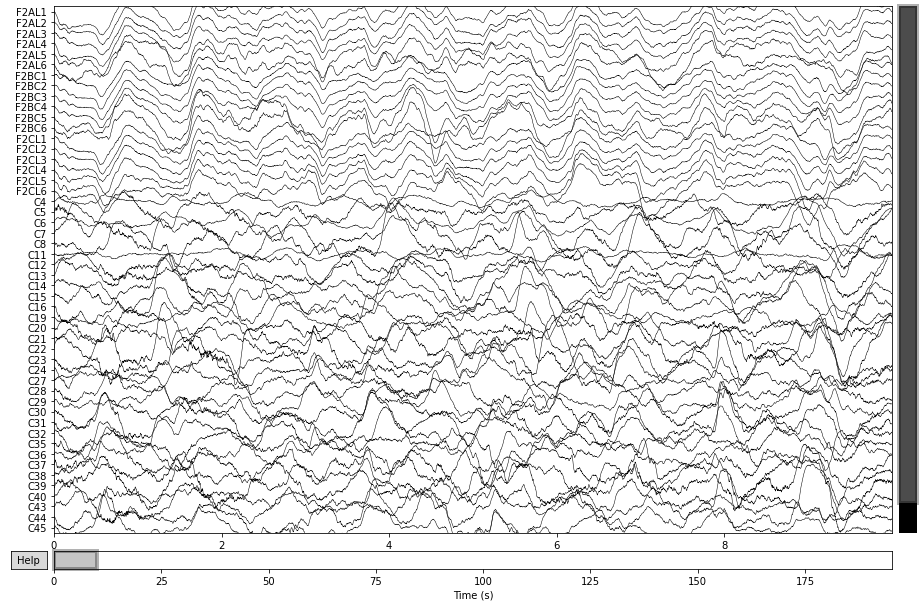

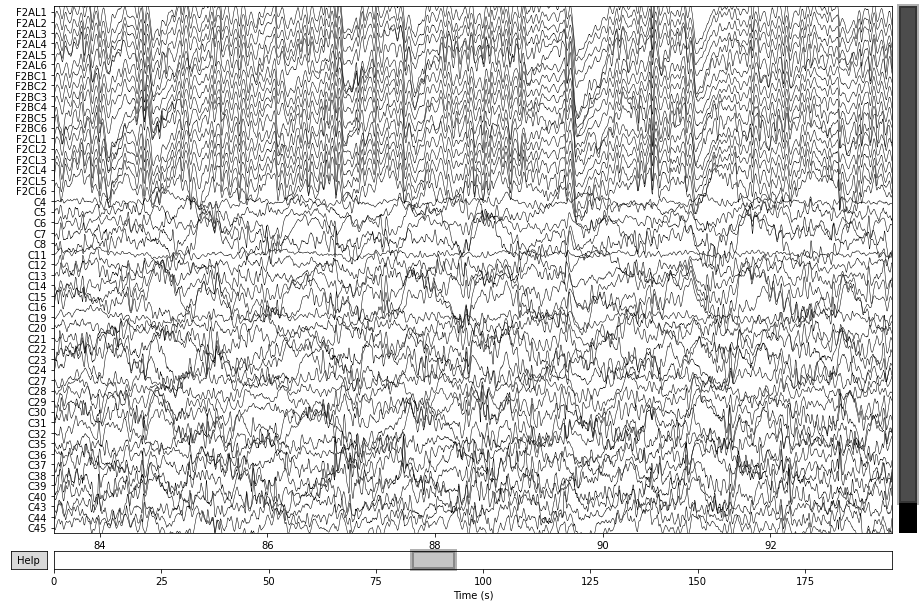

In [9]:
session_raw.set_annotations(None)
for idx in range(events.shape[0]):
    onset = events[idx, 0] / session_raw.info['sfreq']
    session_raw.plot(start=onset, scalings={'seeg': 1e-4, 'ecog': 1e-4}, 
                     clipping=None, n_channels=50, show_scalebars=False,
                     color={'ecog': 'black', 'seeg': 'black'}
    #                 show_scrollbars=False
                    )

In [9]:
deriv_root = root / 'derivatives' / "figures" \
                / f"{int(raw.info['sfreq'])}Hz" \
                / "raw" \
                / reference \
                / f"sub-{subject}"
deriv_root.mkdir(exist_ok=True, parents=True)
fig_basename = bids_path.copy().update(extension='.pdf').basename
print(deriv_root)
print(fig_basename)

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/figures/2049Hz/raw/average/sub-E4
sub-E4_ses-preresection_task-pre_acq-ecog_run-01_ieeg.pdf


In [15]:
scale = 500e-6
fig = raw.plot(
    scalings={
        'ecog': scale, 
        'seeg': scale
    }, n_channels=len(raw.ch_names)
)
fig.savefig(deriv_root / fig_basename)

In [12]:
print(raw.info['bads'])

['C20', 'C27', 'C28']


# Multi-resolution A matrix

In [28]:
model = StructuredPerturbationModel(radius=2.0, perturb_type='C')

In [9]:
eegdata = raw.get_data(start=1000, stop=1500)
print(eegdata.shape)

(53, 500)


In [10]:
dmd = pydmd.MrDMD(svd_rank=53, tlsq_rank=0, exact=True, opt=False,
                  max_level=3)

In [11]:
dmd.fit(eegdata)

(8, 8) (8, 8) (8, 8) (53, 8)
(53, 2) (2, 53)
(8, 8) (8, 8) (8, 8) (53, 8)
(53, 3) (3, 53)
(8, 8) (8, 8) (8, 8) (53, 8)
(53, 1) (1, 53)
(8, 8) (8, 8) (8, 8) (53, 8)
(53, 3) (3, 53)
(8, 8) (8, 8) (8, 8) (53, 8)
(53, 3) (3, 53)
(8, 8) (8, 8) (8, 8) (53, 8)
(53, 3) (3, 53)
(8, 8) (8, 8) (8, 8) (53, 8)
(53, 3) (3, 53)


[62, 31, 31, 15, 15, 15, 15]


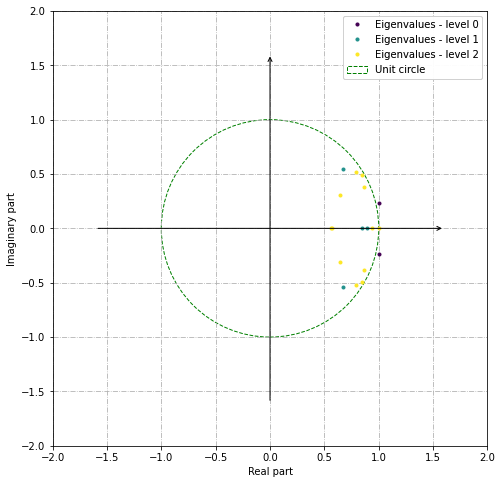

In [12]:
print(dmd._steps)

dmd.plot_eigs()

(53, 53)
2
(53, 53)
3
(53, 53)
1
(53, 53)
3
(53, 53)
3
(53, 53)
3
(53, 53)
3


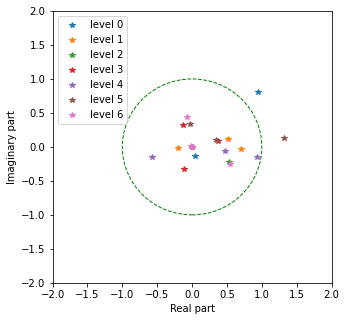

In [26]:
fig, ax = plt.subplots(figsize=(5,5))

for idx, A in enumerate(dmd._Aorig):
    print(A.shape)
    eigs = np.linalg.eigvals(A)
    ax.plot(eigs.real, eigs.imag, '*', label=f'level {idx}')
unit_circle = plt.Circle(
        (0., 0.), 1., color='green', fill=False, linestyle='--')
ax.add_artist(unit_circle)
ax.set(
    xlim=[-2, 2],
    ylim = [-2,2]
)
plt.ylabel('Imaginary part')
plt.xlabel('Real part')
ax.legend()

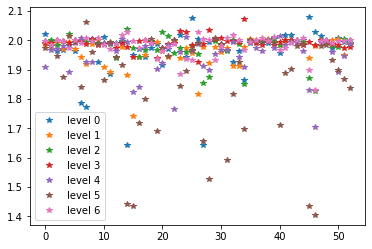

In [30]:
fig, ax = plt.subplots()
for idx, A in enumerate(dmd._Aorig):
    perturb_vec = model.fit(A)
    
    ax.plot(perturb_vec, '*', label=f'level {idx}')
ax.legend()

(53, 53)
(53, 53)
(53, 53)
(53, 53)
(53, 53)
(53, 53)
(53, 53)


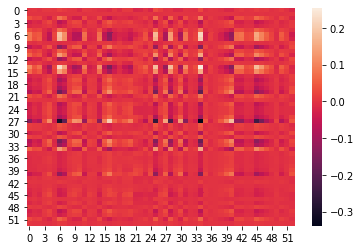

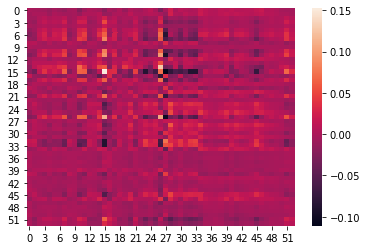

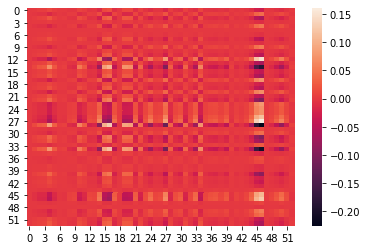

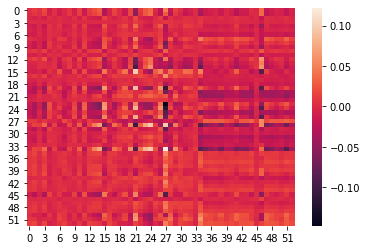

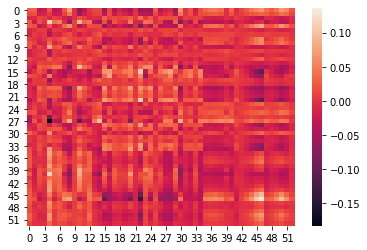

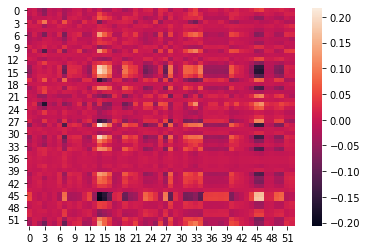

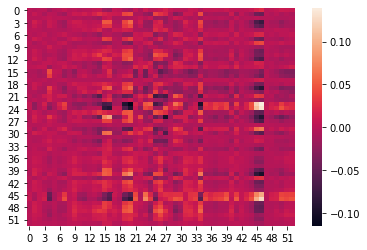

In [16]:
for A in dmd._Aorig:
    print(A.shape)
    plt.figure()
    sns.heatmap(A.real)
    

# Multi-resolution linear operator

In [11]:
print(raw.info)

<Info | 10 non-empty values
 bads: []
 ch_names: C4, C5, C6, C7, C8, C11, C12, C13, C14, C15, C16, C19, C20, C21, ...
 chs: 35 ECOG, 18 SEEG
 custom_ref_applied: False
 dig: 66 items (66 EEG)
 highpass: 0.5 Hz
 line_freq: 60
 lowpass: 500.0 Hz
 meas_date: 2018-01-01 08:53:36 UTC
 nchan: 53
 projs: []
 sfreq: 2049.2 Hz
 subject_info: 16 items (dict)
>


In [12]:
# raw.set_eeg_reference('average')

In [13]:
eegdata = raw.get_data(start=1000, stop=1500)
print(eegdata.shape)

(53, 500)


In [23]:
clf = SystemIDModel(method_to_use='pinv', 
#                     svd_rank=lraw.ch_names,
                    svd_rank=len(raw.ch_names), 
                    tlsq_rank=30
                   )
clf.fit(eegdata.T)


SystemIDModel(svd_rank=53, tlsq_rank=30)

5.19433873194035 53


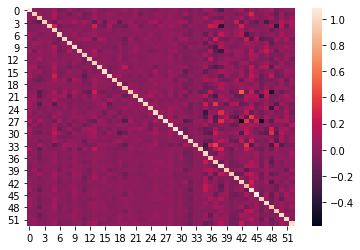

In [22]:
A_dmd = clf.state_array

sns.heatmap(A_dmd)
print(np.linalg.cond(A_dmd), np.linalg.matrix_rank(A_dmd))

1.4939558481706208e+17 30


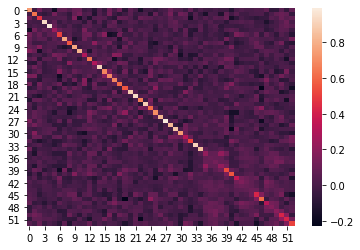

In [24]:
A = clf.state_array

sns.heatmap(A)
print(np.linalg.cond(A), np.linalg.matrix_rank(A))

<AxesSubplot:>

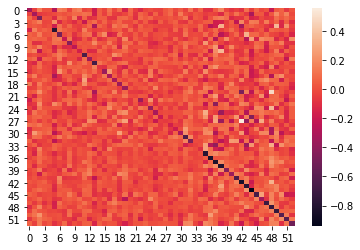

In [25]:
sns.heatmap(A - A_dmd)

In [76]:
X = eegdata[:, :-1]
Y = eegdata[:, 1:]

print(X.shape, Y.shape)

(53, 499) (53, 499)


In [44]:
dmd = pydmd.MrDMD(svd_rank=53, tlsq_rank=0, exact=True, opt=False,
                  max_level=3)

In [45]:
dmd.fit(eegdata)

[62, 31, 31, 15, 15, 15, 15]


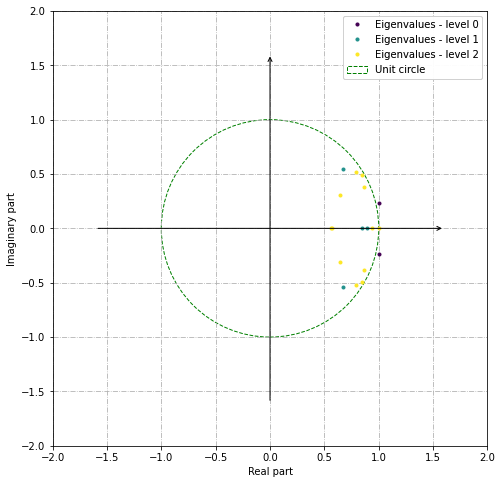

In [46]:
print(dmd._steps)

dmd.plot_eigs()

In [47]:
for A in dmd.atilde:
    print(A.shape, np.linalg.cond(A), np.linalg.matrix_rank(A))

(53, 53) 6.633385773985385e+18 8
(53, 53) 1.0075560076490205e+19 8
(53, 53) 1.7912319926935782e+18 8
(53, 53) 1.4371746237771008e+18 8
(53, 53) 2.0960642458001915e+18 8
(53, 53) 2.817667315085503e+18 8
(53, 53) 3.48959091847993e+18 8


<AxesSubplot:>

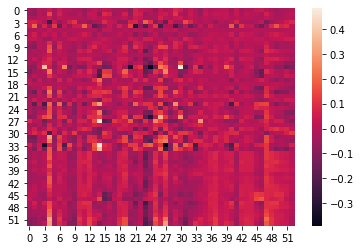

In [48]:
sns.heatmap(A)

(53, 2)
(53, 4)
(53, 12)


ValueError: Invalid level: greater than `max_level`

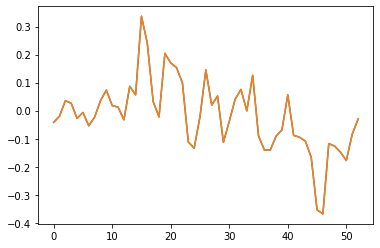

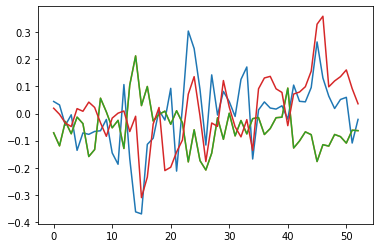

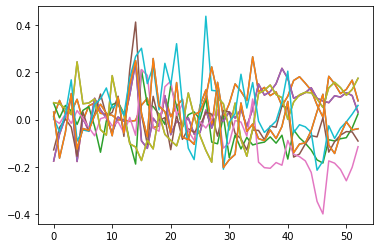

In [49]:
for level in range(5):
    pmodes = dmd.partial_modes(level=level)
    
    plt.figure()
    print(pmodes.shape)
    plt.plot(pmodes.real)

In [149]:
for A in dmd._Atilde:
    print(A.shape)
#     plt.figure()
#     sns.heatmap(A)
    
print('done')

(7, 7)
(8, 8)
(8, 8)
done


In [30]:
def _compute_tlsq(X, Y, tlsq_rank):
    """
    Compute Total Least Square.
    :param numpy.ndarray X: the first matrix;
    :param numpy.ndarray Y: the second matrix;
    :param int tlsq_rank: the rank for the truncation; If 0, the method
        does not compute any noise reduction; if positive number, the
        method uses the argument for the SVD truncation used in the TLSQ
        method.
    :return: the denoised matrix X, the denoised matrix Y
    :rtype: numpy.ndarray, numpy.ndarray
    References:
    https://arxiv.org/pdf/1703.11004.pdf
    https://arxiv.org/pdf/1502.03854.pdf
    """
    # Do not perform tlsq
    if tlsq_rank == 0:
        return X, Y

    V = np.linalg.svd(np.append(X, Y, axis=0), full_matrices=False)[-1]
    rank = min(tlsq_rank, V.shape[0])
    VV = V[:rank, :].conj().T.dot(V[:rank, :])

    return X.dot(VV), Y.dot(VV)
import scipy

In [ ]:
def _forward_multiply(A, x0, t_steps):
    # 2D array of initial conditions (C x samples)
    n_samples, n_chs = X.shape
    
    X_hat = [x0]

    # reconstruct over possibly multiple time steps
    for it in range(t_steps - 1):
        X_hat.append(A.dot(X_hat[-1]))

    # store the predictions
    X_hat = np.array(X_hat).T
    X_pred.append(X_hat)
    # print('inside forward multiply...', np.array(X_pred).shape, n_samples, t_steps)
    return np.asarray(X_pred)


In [31]:
# define snapshots and max level
_snapshots = eegdata
max_level = 6
max_cycles = 2
tlsq_rank = 0

# To avoid recursion function, use FIFO list to simulate the tree
# structure
data_queue = [_snapshots.copy()]

current_bin = 0

# Redefine max level if it is too big.
lvl_threshold = int(np.log(_snapshots.shape[1]/4.)/np.log(2.)) + 1
if max_level > lvl_threshold:
    max_level = lvl_threshold
    print('Too many levels... '
          'Redefining `max_level` to {}'.format(self.max_level))

# Reset the lists
_eigs = []
_Atilde = []
_modes = []
_b = []
_nsamples = []
_steps = []

while data_queue:
    # get the raw data
    Xraw = data_queue.pop(0)

    # compute the number of samples used at this interval
    n_samples = Xraw.shape[1]
    
    # 4 times nyquist limit to capture cycles
    # subsamples frequency to detect slow modes
    nyq = 8 * max_cycles
    
    # sub-sample the data depending on which level we are at
    step = max(1, int(np.floor(n_samples / nyq)))
    Xsub = Xraw[:, ::step]
    Xc = Xsub[:, :-1]
    Yc = Xsub[:, 1:]
    
    # compute total least squares to get the 
    # de-biased X and Y matrices
#     Xc, Yc = _compute_tlsq(Xc, Yc, tlsq_rank)
    
    # compute linear mapping from Xc -> Yc
    Atilde = Yc.dot(scipy.linalg.pinv2(Xc))
#     U, s, V = self._compute_svd(Xc, self.svd_rank)

#     Atilde = self._build_lowrank_op(U, s, V, Yc)
    eigs, eigvecs = scipy.linalg.eig(Atilde)
#     eigs, modes = self._eig_from_lowrank_op(Atilde, Yc, U, s, V,
#                                             self.exact)
    
    # frequency cutoff (oscillations per timestep)
    rho = float(max_cycles) / n_samples
    
    # determine slow eigenvalues as a boolean mask
    slow_vals = np.abs(np.log(eigs) / (2. * np.pi * step))
    slow_modes = slow_vals <= rho

    # keep the slow modes and eigenvalues
#     modes = modes[:, slow_modes]
    sloweigs = eigs[slow_modes]
    sloweigvecs = eigvecs[:, slow_modes]
    eigsmat = np.pad(sloweigs, (0, len(eigs) - len(sloweigs)))
    Aslow = eigvecs @ np.diag(eigsmat) @ np.linalg.inv(eigvecs)
#     break
    #---------------------------------------------------------------
    # DMD Amplitudes and Dynamics
    #---------------------------------------------------------------
    # form the vandermonte matrix to evolve dynamics in time
    Vand = np.vander(
        np.power(eigs, 1./ step), n_samples, True)
    b = np.linalg.lstsq(sloweigvecs, Xc[0], rcond=None)[0]

#     b = self._compute_amplitudes(modes, Xc, eigs, self.opt)

    Psi = (Vand.T * b).T

#     self._modes.append(modes)
#     self._b.append(b)
    _Atilde.append(Atilde)
    _eigs.append(eigs)
    _nsamples.append(n_samples)
    _steps.append(step)

    # 
#     Xraw -= modes.dot(Psi)
    data = sloweigvecs.dot(Psi)
    Xraw -= data

    if current_bin < 2**(max_level - 1) - 1:
        current_bin += 1
        half = int(np.ceil(old_div(Xraw.shape[1], 2)))
        data_queue.append(Xraw[:, :half])
        data_queue.append(Xraw[:, half:])
    else:
        current_bin += 1

# self.dmd_time = {'t0': 0, 'tend': self._snapshots.shape[1], 'dt': 1}
# self.original_time = self.dmd_time.copy()


ValueError: operands could not be broadcast together with shapes (500,53) (4,) 

In [37]:

print(Xc.shape)
print(sloweigvecs.shape)
print(b.shape)
print(Xc[0].shape)

b = np.linalg.lstsq(sloweigvecs, Xc[0], rcond=None)[0]

(53, 16)
(53, 4)
(4,)
(16,)


LinAlgError: Incompatible dimensions

In [ ]:
data = Aslow.dot()

<AxesSubplot:>

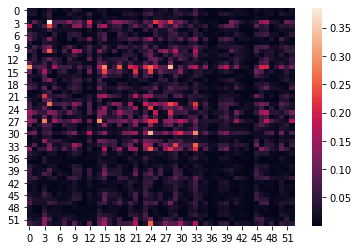

In [29]:
sns.heatmap(np.abs(Aslow))

In [67]:
print(eigvecs.shape, eigsmat.shape)
print(slow_modes)
eigvecs.shape[0] - len(eigs)
print(eigvecs.shape[0], len(sloweigs))

(66, 66) (66,)
[False False False False  True  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
66 3


In [68]:
print(slow_vals)
# print(np.abs(eigs))

[0.02500334 0.02500334 0.00560181 0.00560181 0.00134219 0.00186398
 0.00186398 0.00283418 0.00283418 0.00690901 0.00690901 0.00818237
 0.00544988 0.00544988 0.00395473 0.00395473 0.01996935 0.02020659
 0.02020659 0.01984034 0.01984034 0.02111639 0.02111639 0.02056009
 0.02106752 0.02106752 0.02180767 0.02180767 0.02259815 0.02259815
 0.02253699 0.02253699 0.02165    0.02217637 0.02217637 0.02294206
 0.02294206 0.02279801 0.02279801 0.02428061 0.02307366 0.02348793
 0.02389238 0.02389238 0.02441492 0.02441492 0.02511271 0.02511271
 0.02626247 0.02709174 0.02709174 0.02762446 0.02762446 0.0291379
 0.03202245 0.04873724 0.09480036 0.0897958  0.09760383 0.09901053
 0.11195461 0.11533827 0.11659358 0.11719243 0.11719243 0.1191295 ]


In [69]:
print(rho)
print()

0.002



# Try some stuff - kernel Regression

In [7]:
from sklearn.kernel_ridge import KernelRidge

from eztrack.fragility import DiscreteLinearSystem

In [90]:
clf = KernelRidge(alpha=1e-8, kernel='laplacian', gamma=None)

In [91]:
eegdata = raw.get_data(start=0, stop=250)
print(eegdata.shape)

(66, 250)


In [109]:
X = eegdata[:, :-1].T
Y = eegdata[:, 1:].T

print(X.shape, Y.shape)

(249, 66) (249, 66)


In [110]:
clf.fit(X, Y)

KernelRidge(alpha=1e-08, kernel='laplacian')

In [111]:
yhat = clf.predict(X[1:2, :])
print(yhat.shape)

(1, 66)


In [112]:
print(clf.dual_coef_.shape)

(249, 66)


Done
6.662558227251915e-09


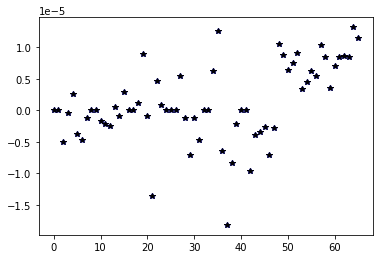

In [114]:
plt.plot(yhat.flatten(), 'b*')
plt.plot(Y[1, :], 'k*')
print('Done')
print(np.sum(Y[1,:] - yhat.flatten()))

In [115]:
print(clf.get_params())

{'alpha': 1e-08, 'coef0': 1, 'degree': 3, 'gamma': None, 'kernel': 'laplacian', 'kernel_params': None}


In [116]:
print(clf.dual_coef_.shape)
print(clf.X_fit_.shape)

(249, 66)
(249, 66)


In [119]:
K = clf._get_kernel(X, X[0:1, :])
print(K.shape)

(249, 1)


<AxesSubplot:>

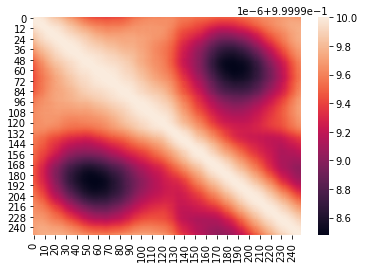

In [23]:
sns.heatmap(K)

In [24]:
import numpy as np
print(np.abs(np.linalg.eigvals(K)))

[2.48999865e+02 7.96616624e-05 3.36741695e-05 1.04392056e-05
 5.60611878e-06 2.70305670e-06 1.19631746e-06 8.13762003e-07
 3.17706093e-07 2.48010837e-07 1.22804039e-07 4.08440487e-08
 3.73582689e-08 2.45142665e-08 2.32941015e-08 1.32560786e-08
 1.14064131e-08 5.07996713e-09 4.07747375e-09 3.78509017e-09
 1.93017964e-09 1.74763860e-09 1.64454807e-09 1.34457714e-09
 1.02145778e-09 8.82976602e-10 6.86758769e-10 5.27702999e-10
 5.27702999e-10 3.47965733e-10 3.35319193e-10 2.68849402e-10
 1.94194522e-10 1.94194522e-10 1.90545969e-10 1.90545969e-10
 1.08212036e-10 1.08212036e-10 8.45369799e-11 8.45369799e-11
 8.71663150e-11 8.71663150e-11 6.23814734e-11 6.23814734e-11
 5.13229182e-11 4.55225879e-11 4.55225879e-11 4.13674849e-11
 4.13674849e-11 3.50075843e-11 2.21174349e-11 2.21174349e-11
 1.29016872e-11 1.29016872e-11 9.08068333e-12 9.80945796e-15
 5.08251775e-15 4.36932780e-15 4.36932780e-15 3.95481854e-15
 3.95481854e-15 3.53523365e-15 3.39578962e-15 3.39578962e-15
 3.42607252e-15 3.426072

/Users/adam2392/Documents/eztrack/eztrack/fragility/linearsystem.py:326: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x14a5e68e0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend([points, unit_circle], ["Eigenvalues", "Unit circle"], loc=1)


<AxesSubplot:xlabel='Real part', ylabel='Imaginary part'>

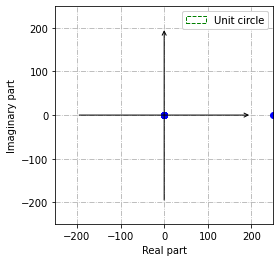

In [25]:
lds = DiscreteLinearSystem(K)
lds.plot_eigs()